Próposito: Indica si la empresa cotiza debajo de su fair value (fórmula Graham) lógica del sistema conservadora. 
Fallo: Empresas con perdidas historicas, EPS erraticos o alta volatilidad.

Graham fue diseñado en 1950 para empresas industriales maduras.

In [11]:
#Extrae los datos fundamentales de la empresa.

import yfinance as yf

TICKER = "AAPL"  # Cambia esto por el ticker que deseas analizar
stock = yf.Ticker(TICKER)
info = stock.info

TICKER_SYMBOL = info.get('symbol', TICKER)
precio_actual = info.get('currentPrice') or info.get('regularMarketPrice') or info.get('previousClose')
precio_analistas = round(info.get('targetMeanPrice', 0), 2)
eps = info.get('trailingEps') 
financials = stock.get_earnings_dates(limit=20)

#(Debug)
print(f"Datos cargados para: {TICKER_SYMBOL}")
print(f"Precio capturado: ${precio_actual}")
print(f"Precio concenso de analistas: ${precio_analistas}")
print(f"Earnings per share: ${eps}")

Datos cargados para: AAPL
Precio capturado: $255.78
Precio concenso de analistas: $292.15
Earnings per share: $7.9


In [12]:
# Sección value investing (fórmula de Graham)

def obtener_g(stock): 
    try:
        # Cálculo historico.
        financials = stock.income_stmt
        serie_eps = (financials.loc['Net Income'] / stock.info.get('sharesOutstanding', 1)).dropna()  # ← ÚNICO CAMBIO
        
        if len(serie_eps) >= 4:
            eps_reciente = serie_eps.iloc[0]
            eps_antiguo = serie_eps.iloc[-1]
            años = len(serie_eps) / 4
            if eps_antiguo != 0 and eps_reciente > 0 and (eps_reciente > eps_antiguo):
                g_calculada = ((eps_reciente / eps_antiguo) ** (1 / años) - 1) * 100
                return max(0, min(g_calculada, 15))
        
        # Cálculo proyectado.
        g_proyectada = stock.info.get('earningsQuarterlyGrowth')
        if g_proyectada and g_proyectada > 0.01:
            return max(0, min(g_proyectada * 100, 15))
    except Exception as e:
        print(f"Aviso: Fallo en extraer el crecimiento.({e})")
    
    # Fallback.
    return 7.0 if (eps and eps > 0) else 5.0

#Ejecución.
g = obtener_g(stock)

#Calcula el fair value de la empresa con fórmula de Graham.
if eps is not None and eps > 0: 
    fair_value_graham = round(eps * (8.5 + 2 * g), 2)

else:
    fair_value_graham = 0 

analisis_fundamental = {
    'Actual': precio_actual,
    'Analistas': precio_analistas,
    'FairValue': fair_value_graham,
    'EPS': eps
}

print(f"ANÁLISIS SOBRE {TICKER}:")
print(f"Valor Graham: ${fair_value_graham} (basado en un crecimiento del {g:.2f}%)")


ANÁLISIS SOBRE AAPL:
Valor Graham: $260.4 (basado en un crecimiento del 12.23%)


In [13]:
#Detector de precios burbuja.

p_graham = analisis_fundamental['FairValue'] 
p_mercado = analisis_fundamental['Actual']   
analisis_fundamental['EPS'] = eps

#Cálculo del ratio entre el Valor de Graham y el Precio de Mercado. Si el Valor de Graham es menos del 60% del precio de mercado,
# significa que el precio está inflado un 40% o más por encima de sus fundamentos.
def detectar_burbuja(p_mercado, p_graham):
    
    ratio_valor = p_mercado/ p_graham # Compara que tanto del precio esta respaldado por valor real
    
    #definimos el umbral de "burbuja": Un ratio < 0.60 significa que el 40% del precio especulación.
    if ratio_valor < 0.60: 
        print(f"ALERTA DE BURBUJA!: El valor real de la empresa {TICKER} de USD(${p_graham}) solo cubre el {round(ratio_valor*100)}% del precio.") # Notifica la brecha
        return True
    else:
        print(f"VALUACIÓN SANA: El fundamento respalda el {round(ratio_valor*100)}% del precio.")
        return False


alerta_activa = detectar_burbuja(p_mercado, p_graham) # Ejecuta la función

# --- AUDITORÍA TÉCNICA FINAL ---
# Usamos directamente la variable 'eps' que ya tenemos validada
eps_audit = eps if eps and eps > 0 else 1 

per_calc = p_mercado / eps_audit
g_req = (per_calc - 8.5) / 2


print(f"Para justificar ${p_mercado:.2f}, el mercado asume un crecimiento del {g_req:.2f}% anual.")

if g_req > 15: # umbral sobre optimismo excesivo
    print("Este crecimiento es superior al límite de Graham (15%), indicio de sobrevaloración.")

VALUACIÓN SANA: El fundamento respalda el 98% del precio.
Para justificar $255.78, el mercado asume un crecimiento del 11.94% anual.


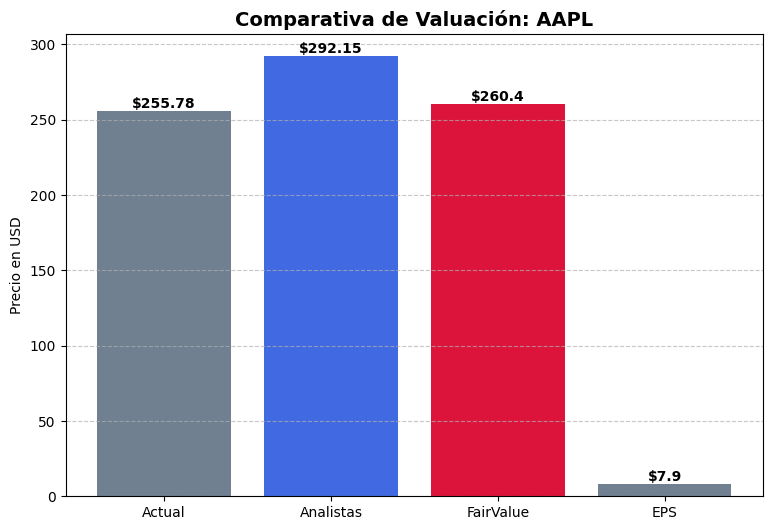


RESUMEN ANÁLISIS FUNDAMENTAL: AAPL

  Precio Actual (Mercado): $255.78
  Precio Objetivo Analistas: $292.15
  Fair Value Graham: $260.40
  EPS (Trailing 12m): $7.90
  Tasa Crecimiento (g): 12.23%

  P/E Ratio (Mercado): 32.38x


In [14]:
#Gráfico de barras comparativo: precio actual vs precio objetivo vs precio Graham
import matplotlib.pyplot as plt

# 1. Preparar los datos del diccionario
nombres = list(analisis_fundamental.keys())
valores = list(analisis_fundamental.values())

# 2. Crear el gráfico
plt.figure(figsize=(9, 6))
barras = plt.bar(nombres, valores, color=['slategray', 'royalblue', 'crimson'])

# 3. Estética simple
plt.title(f'Comparativa de Valuación: {TICKER}', fontsize=14, fontweight='bold')
plt.ylabel('Precio en USD')
plt.grid(axis='y', linestyle='--', alpha=0.7)


# Añadir los números encima de las barras para que se lean fácil
for barra in barras:
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, yval, f'${yval}', 
             va='bottom', ha='center', fontweight='bold')

plt.show()

# Print final
print("\n" + "="*60)
print(f"RESUMEN ANÁLISIS FUNDAMENTAL: {TICKER}")
print("="*60)
print(f"\n  Precio Actual (Mercado): ${precio_actual:.2f}")
print(f"  Precio Objetivo Analistas: ${precio_analistas:.2f}")
print(f"  Fair Value Graham: ${fair_value_graham:.2f}")
print(f"  EPS (Trailing 12m): ${eps:.2f}")
print(f"  Tasa Crecimiento (g): {g:.2f}%")
print(f"\n  P/E Ratio (Mercado): {(precio_actual/eps):.2f}x" if eps > 0 else "  P/E Ratio: N/A")

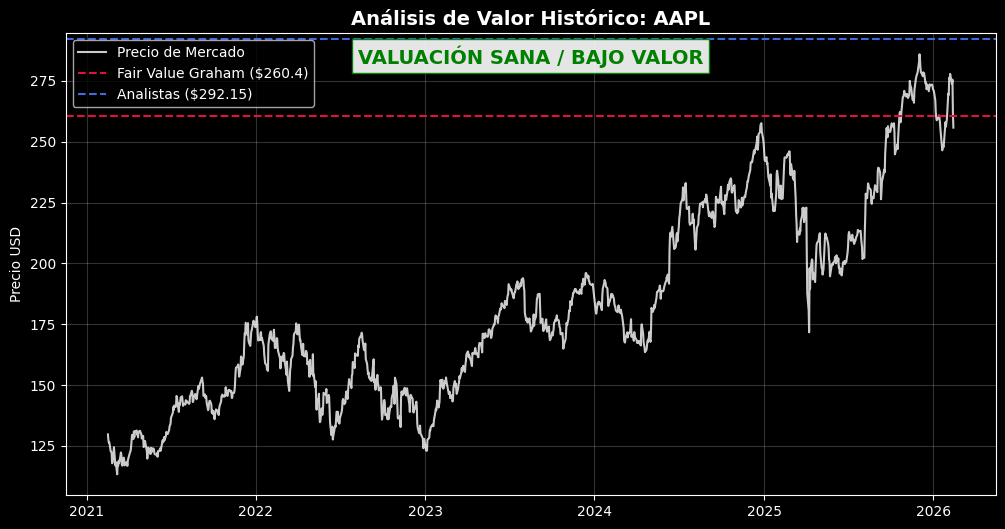

In [15]:
#Gráfico de Línea de Tiempo comparativo: precio de mercado vs precio objetivo vs precio Graham
import matplotlib.pyplot as plt
import yfinance as yf

plt.style.use('dark_background')

# Obtenemos solo el histórico de precios.
h_precios = stock.history(period="5y")  # Últimos 5 años para un análisis más relevante

# Recuperamos las variables del diccionario de la celda anterior
p_actual = analisis_fundamental['Actual']
p_analistas = analisis_fundamental['Analistas']
p_graham = analisis_fundamental['FairValue']

# Definimos la alerta basada en Graham.
margen_seguridad = 1.10 # 10% de tolerancia
alerta_activa = p_actual > (p_graham * margen_seguridad)

# --- MÓDULO: Gráfico de Línea de Tiempo ---
plt.figure(figsize=(12, 6))
plt.plot(h_precios.index, h_precios['Close'], label='Precio de Mercado', color='white', alpha=0.8)

plt.axhline(y=p_graham, color='crimson', linestyle='--', label=f'Fair Value Graham (${p_graham})')
plt.axhline(y=p_analistas, color='royalblue', linestyle='--', label=f'Analistas (${p_analistas})')

plt.title(f'Análisis de Valor Histórico: {TICKER}', fontsize=14, fontweight='bold')
plt.ylabel('Precio USD')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.2)

# Lógica visual de alerta REFORMULADA
if alerta_activa:
    mensaje_visual = "ALERTA: SOBREVALORACIÓN" 
    color_alerta = 'red' 
    # Si además el precio es mayor al de los analistas, la burbuja es crítica

else:
    mensaje_visual = "VALUACIÓN SANA / BAJO VALOR"
    color_alerta = 'green' 

# Renderizado del cuadro de texto
plt.text(0.5, 0.95, mensaje_visual, 
         color=color_alerta, fontsize=14, fontweight='bold', 
         ha='center', va='center', transform=plt.gca().transAxes,  
         bbox=dict(facecolor='white', alpha=0.9, edgecolor=color_alerta))

plt.show()